In [1]:
import os
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import mplfinance as fplt

In [2]:
def plot(data, title=''):
    """
    Plots candlestick data, that conforms to mplfinance layout
    """
    mc = fplt.make_marketcolors(
                                up='green',down='red',
                                edge='yellow',
                                wick='inherit',
                                #volume='inherit',
                                ohlc='inherit'
                               )
    s  = fplt.make_mpf_style(base_mpl_style='seaborn', marketcolors=mc, mavcolors=["green", "red", "purple"])

    fplt.plot(data,
              type='candle',
              style=s, #'charles',
              title=title,
              ylabel='Price ($)',
              volume=False,
              ylabel_lower='Shares\nTraded',
              figratio=(30, 10),
    )

In [3]:
!pwd

/Users/wgiersche/workspace/financials/realmoney


In [4]:
file = "DATA/etf-complete_tickers_O-S_1min_72bwe/SOXL_1min.txt"

In [7]:
df = pd.read_csv(file, names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], header=None)

In [8]:
df['Date'] = df['Date'].map(lambda d: dt.datetime.strptime(d, '%Y-%m-%d %H:%M:%S'))

In [9]:
df['Day'] = df['Date'].map(lambda d: d.date())

In [10]:
df.drop_duplicates(inplace=True)

---

# Oct 23, 2020

In [11]:
df_23_10 = df[df['Day'] == dt.date(2020, 10, 23)]
df_23_10

,Date,Open,High,Low,Close,Volume,Day
755911,2020-10-23 06:33:00,286.22,286.22,286.22,286.22,400,2020-10-23
755912,2020-10-23 06:38:00,287.00,287.00,287.00,287.00,199,2020-10-23
755913,2020-10-23 07:55:00,293.50,293.50,293.50,293.50,200,2020-10-23
755914,2020-10-23 09:14:00,293.00,293.00,293.00,293.00,100,2020-10-23
755915,2020-10-23 09:29:00,292.41,292.41,292.41,292.41,200,2020-10-23
...,...,...,...,...,...,...,...
756229,2020-10-23 18:28:00,290.59,290.59,290.59,290.59,100,2020-10-23
756230,2020-10-23 18:30:00,290.55,290.55,290.55,290.55,0,2020-10-23
756231,2020-10-23 18:37:00,290.58,290.59,290.58,290.59,340,2020-10-23
756232,2020-10-23 18:38:00,290.61,290.61,290.61,290.61,100,2020-10-23


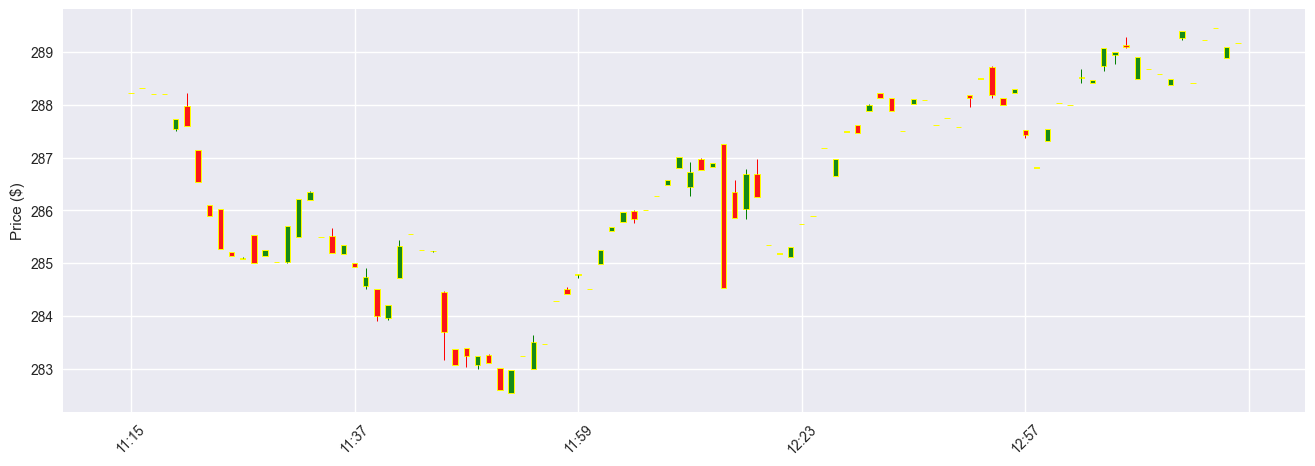

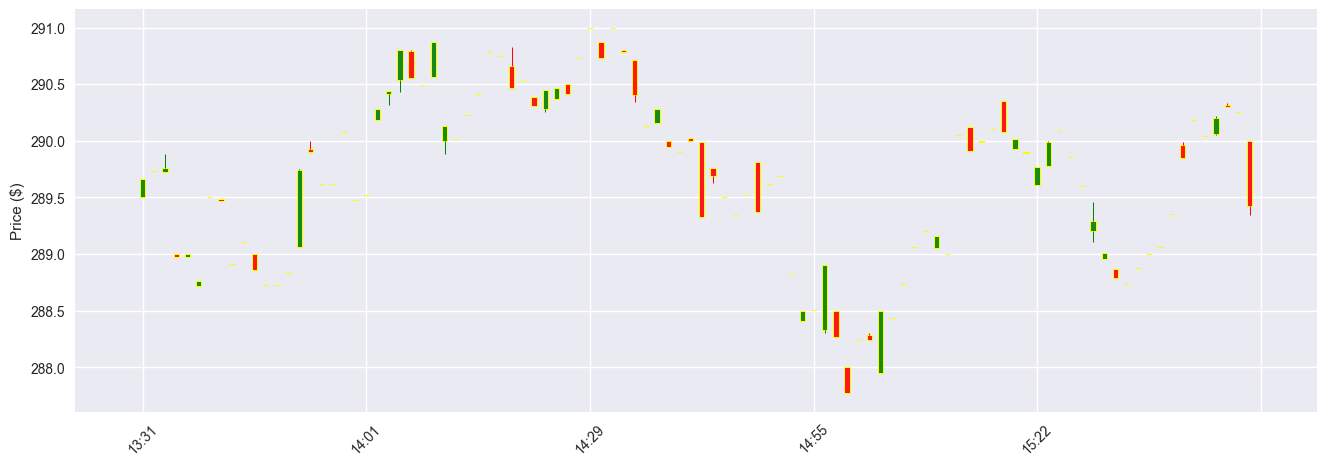

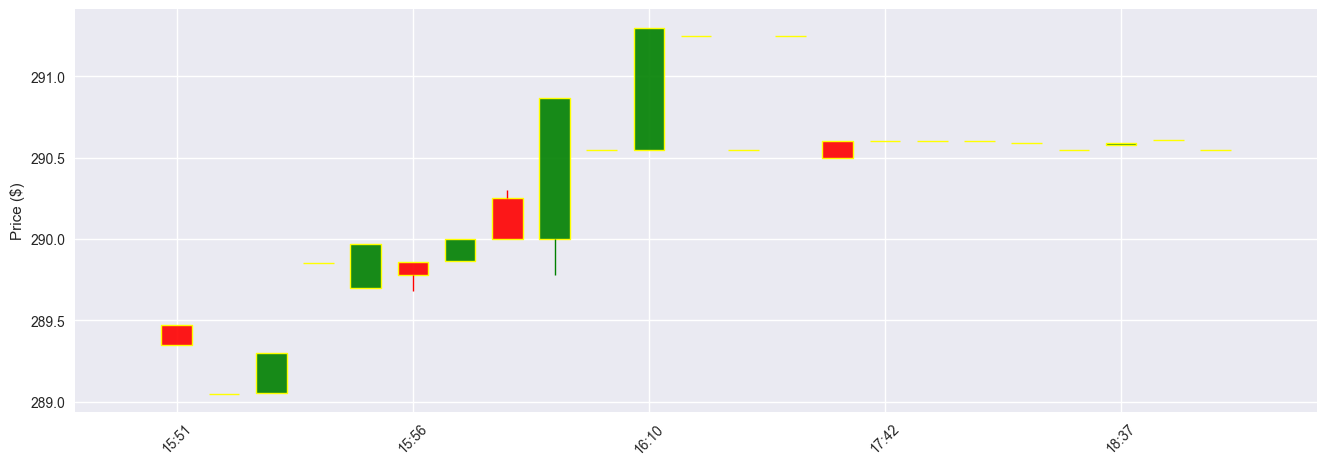

In [13]:
data = df_23_10.copy()
data.set_index(pd.DatetimeIndex(data['Date']), inplace=True)
#plot(data[:])
plot(data[100:200])
plot(data[200:300])
plot(data[300:])

In [10]:
cols = ['High', 'Low', 'Close', 'Open']
df_23_10 = df_23_10.copy()
df_23_10 = df_23_10[cols]
deltas = []
c_p = None
for i, row in df_23_10.iterrows():    
    o, h, l, c = row['Open'], row['High'], row['Low'], row['Close']
    if c_p == None:
        c_p = c
    else:
        #deltas += [c - o]
        deltas += ([l - c_p, h - l, c - h] 
                   if c - o > 0 else 
                   [h - c_p, l - h, c - l])
        c_p = c
    

In [11]:
deltas = [d for d in deltas if d != 0]
len(deltas), sum(deltas)

(1095, 10.079999999999927)

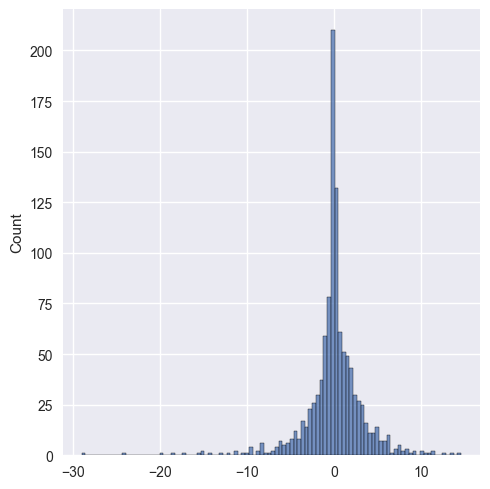

In [13]:
sns.displot(deltas);

In [14]:
import statistics as stats
s = stats.stdev(deltas)
s

3.4096918549175252

In [15]:
small_contrib = sum([d for d in deltas if abs(d) < s])
big_contrib = sum([d for d in deltas if abs(d) >= s])
small_contrib, big_contrib

(75.0299999999952, -64.94999999999527)

In [16]:
len(df)

80550

In [17]:
start = '2020-06-01'
end = '2020-10-23'
start_date = dt.datetime.strptime(start, '%Y-%m-%d').date()
end_date = dt.datetime.strptime(end, '%Y-%m-%d').date()
range = pd.date_range(start=start, end=end).to_pydatetime().tolist()

In [18]:
scale = 4
cols = ['High', 'Low', 'Close', 'Open']
res = {'Date': [], 'Small': [], 'Big': []}
for date in range:
    df_day = df[df['Day'] == date.date()].copy()[cols]
    if len(df_day) == 0:
        continue
    deltas = []
    c_p = None
    for i, row in df_day.iterrows():    
        o, h, l, c = row['Open'], row['High'], row['Low'], row['Close']
        if c_p == None:
            c_p = c
        else:
            deltas += [c - o]
#             deltas += ([l - c_p, h - l, c - h] 
#                        if c - o > 0 else 
#                        [h - c_p, l - h, c - l])
            c_p = c
    
    s = 1 * stats.stdev(deltas)
    small_contrib = sum([d for d in deltas if abs(d) < s])
    big_contrib = sum([d for d in deltas if abs(d) >= s])

    res['Date'].append(date)
    res['Small'].append(small_contrib/scale)
    res['Big'].append(big_contrib/scale)

In [19]:
big_vs_small = pd.DataFrame.from_dict(res)

<Figure size 4000x2000 with 0 Axes>

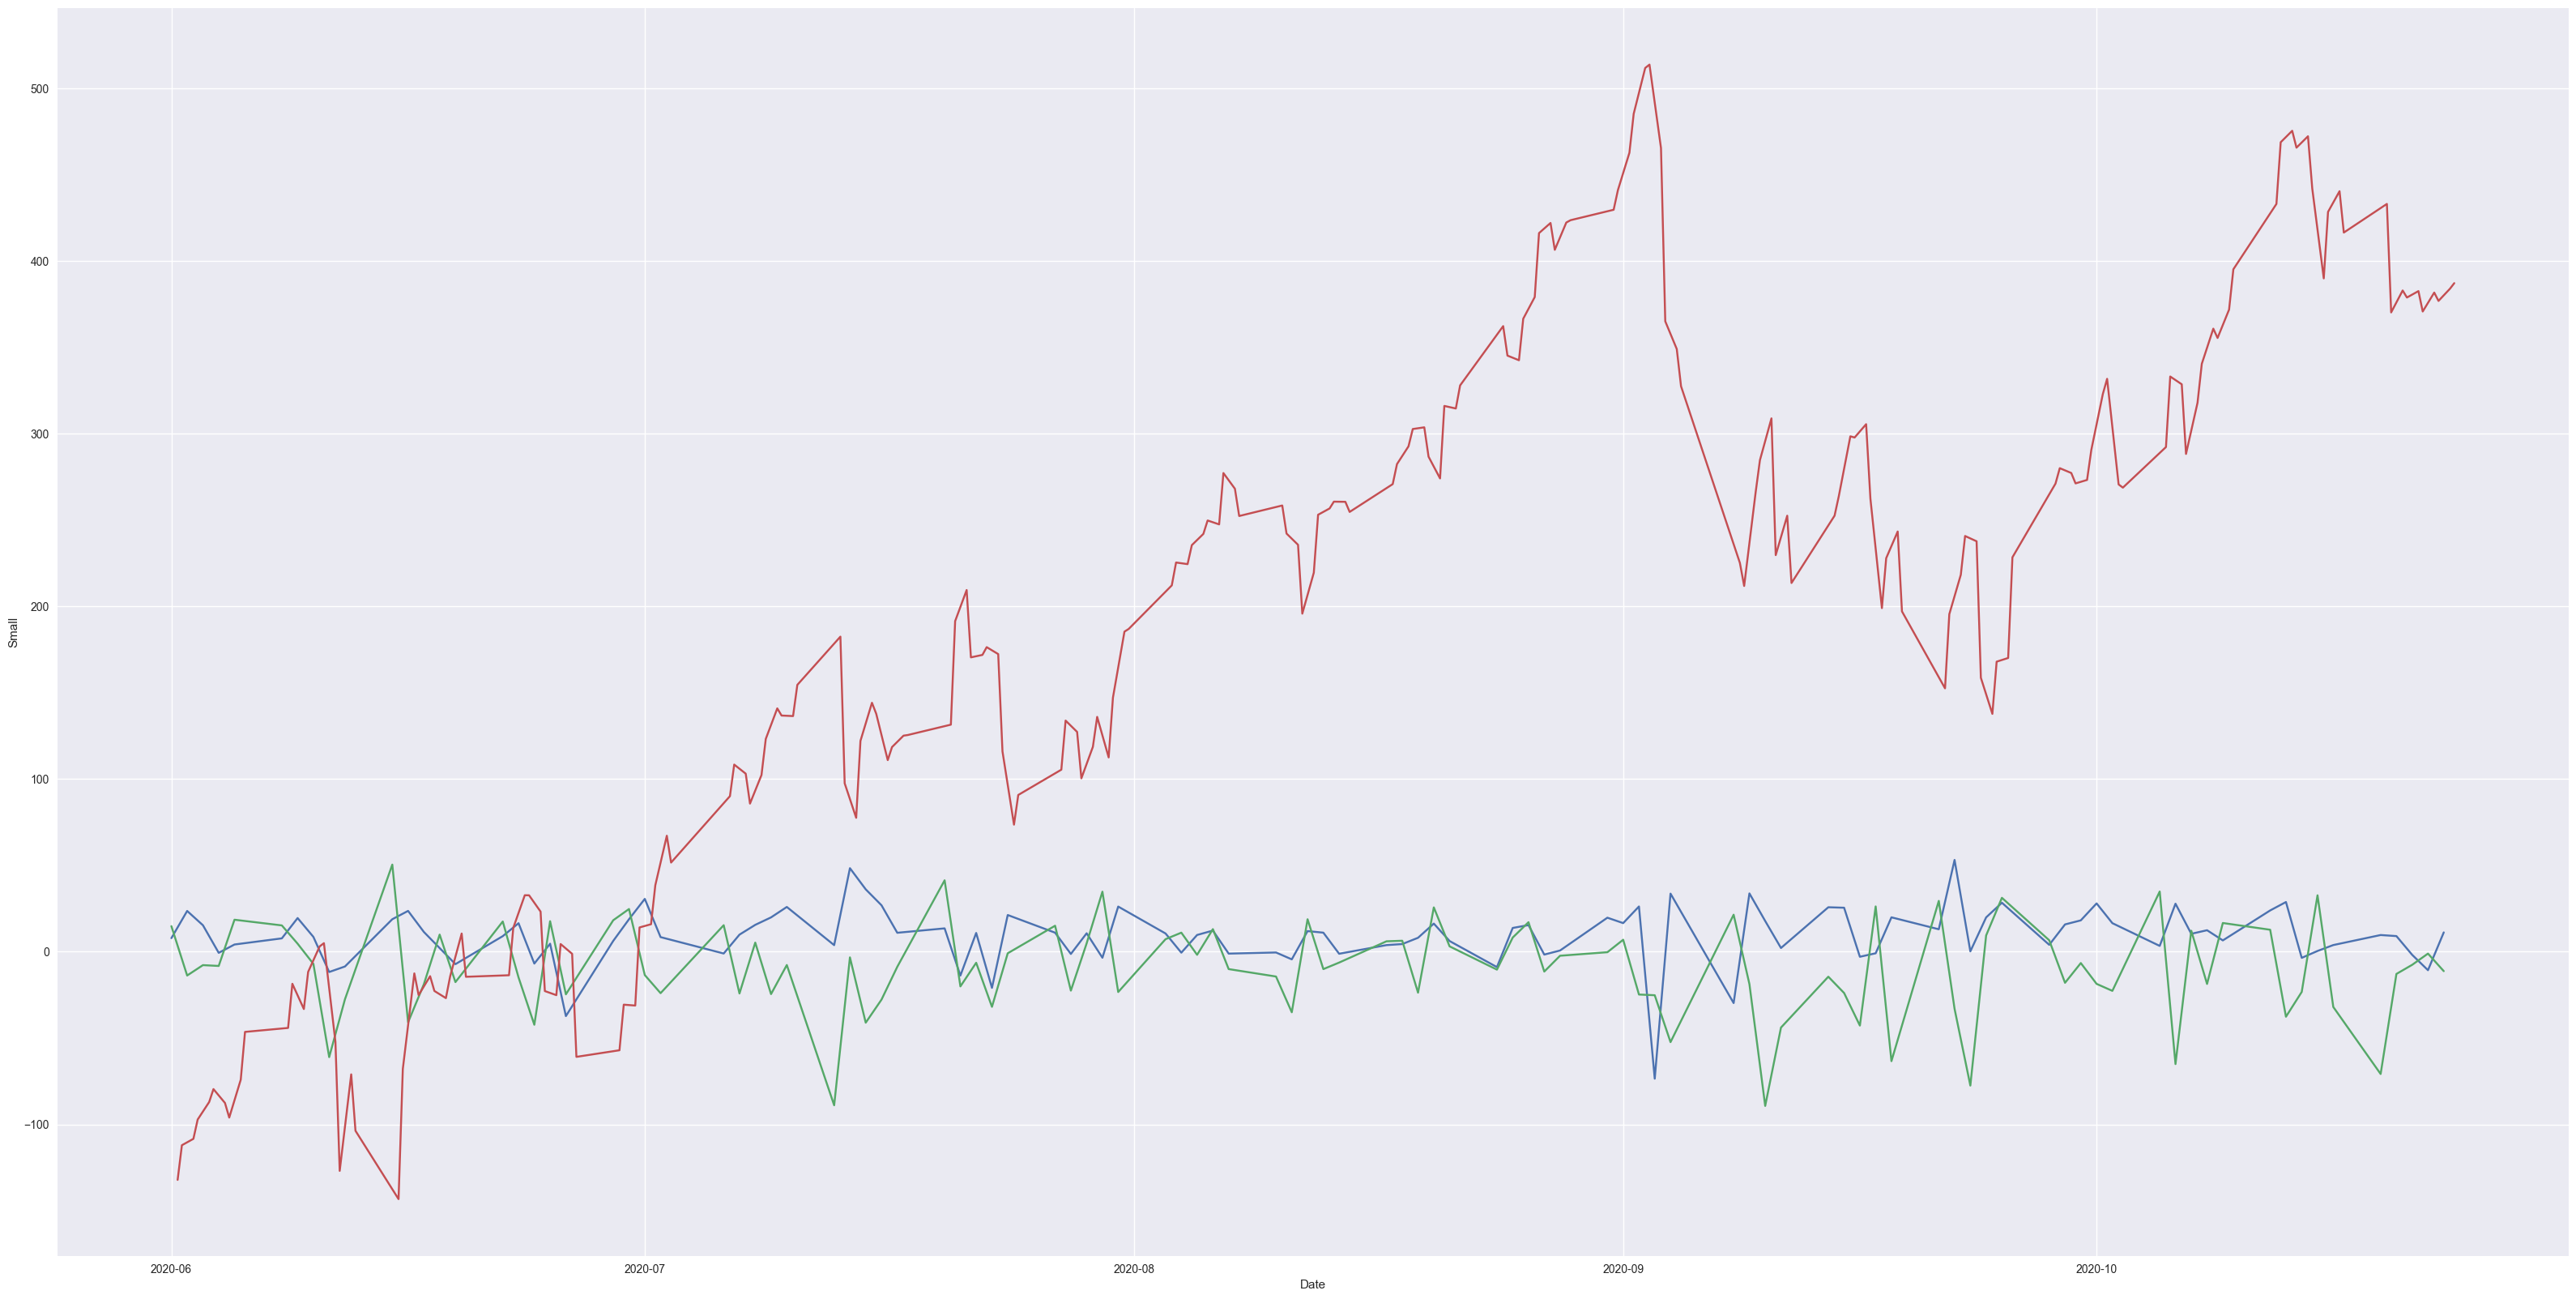

In [20]:
from matplotlib import pyplot as plt
plt.figure(figsize=(40,20))

plt.figure(figsize=(40,20))
chart = df.copy()
chart['selected']=chart['Date'].map(lambda d: ((d.hour == 16 and d.minute == 0) or (d.hour == 9 and d.minute == 30)) and d.date() >= start_date and d.date() <= end_date )
chart = chart[chart['selected']]

chart.set_index(pd.DatetimeIndex(chart['Date']), inplace=True)
chart['projected'] = chart['Open']/scale - 2500
sns.lineplot(data=big_vs_small, x='Date', y='Small')
sns.lineplot(data=big_vs_small, x='Date', y='Big')
sns.lineplot(data=chart, x='Date', y='projected');

In [21]:
chart_orig = df[20000:].copy()

In [22]:
pd.set_option('display.max_rows', 200)
chart_orig[23200:23400]

,Date,Open,High,Low,Close,Day
43200,2020-06-10 12:38:00,10012.39,10015.64,10012.23,10015.43,2020-06-10
43201,2020-06-10 12:39:00,10015.60,10016.10,10013.94,10015.19,2020-06-10
43202,2020-06-10 12:40:00,10015.28,10015.44,10013.64,10014.07,2020-06-10
43203,2020-06-10 12:41:00,10014.23,10017.80,10013.78,10017.76,2020-06-10
43204,2020-06-10 12:42:00,10017.68,10018.76,10016.90,10017.02,2020-06-10
43205,2020-06-10 12:43:00,10016.96,10016.96,10014.02,10014.22,2020-06-10
43206,2020-06-10 12:44:00,10014.30,10016.63,10014.30,10015.11,2020-06-10
43207,2020-06-10 12:45:00,10015.09,10015.09,10013.28,10013.67,2020-06-10
43208,2020-06-10 12:46:00,10013.43,10013.73,10011.77,10012.25,2020-06-10
43209,2020-06-10 12:47:00,10012.33,10016.63,10012.33,10015.99,2020-06-10
